<a href="https://colab.research.google.com/github/zerxe/CEIABDAT/blob/main/SNS/SNS_Actividad_3_6_DengAI_predicci%C3%B3n_de_la_propagaci%C3%B3n_de_enfermedades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad 3.6 - DengAI: predicción de la propagación de enfermedades

Adolfo Morales Colmenares


## Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import randint
import warnings
warnings.filterwarnings('ignore')

## Carga del dataset

Uso de GitHub como almacenamiento del dataset

In [17]:
features = pd.read_csv('https://raw.githubusercontent.com/zerxe/CEIABDAT/refs/heads/main/SNS/dengue_features_train.csv')
labels = pd.read_csv('https://raw.githubusercontent.com/zerxe/CEIABDAT/refs/heads/main/SNS/dengue_labels_train.csv')
test_features = pd.read_csv('https://raw.githubusercontent.com/zerxe/CEIABDAT/refs/heads/main/SNS/dengue_features_test.csv')
data = pd.merge(features, labels, on=["city", "year", "weekofyear"])

## Preparación de los datos

In [29]:
features_numeric = data.select_dtypes(include=[np.number]).interpolate().fillna(method='bfill')
data.update(features_numeric)

training_features = features_numeric.drop("total_cases", axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(training_features)

## Selección de características

In [9]:
selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(scaled_features, data['total_cases'])
selected_features = selector.get_support(indices=True)
selected_columns = features_numeric.drop("total_cases", axis=1).columns[selected_features]

## División de los datos

In [10]:
X = features_numeric[selected_columns]
y = data['total_cases']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Matriz de correlación

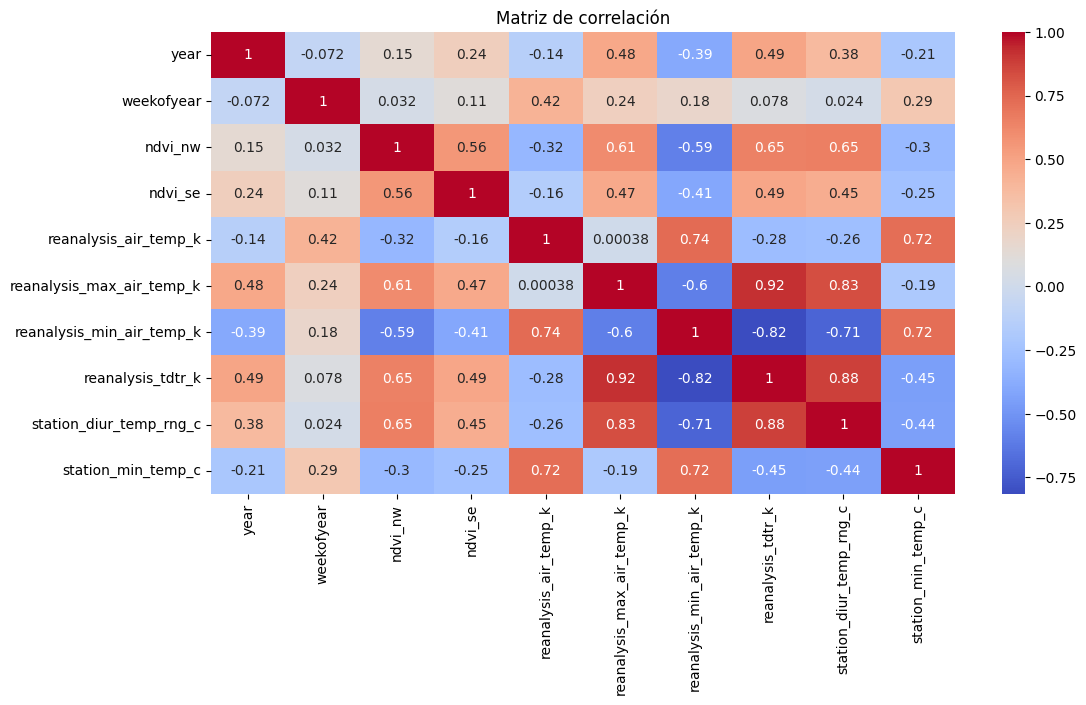

In [11]:
plt.figure(figsize=(12, 6))
sns.heatmap(data[selected_columns].corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

## Modelos

### NaiveBayes

In [12]:
# GridSearch
param_grid_nb = {'var_smoothing': np.logspace(-11, -7, 5)}
gs_nb = GridSearchCV(GaussianNB(), param_grid=param_grid_nb, cv=5, scoring='neg_mean_absolute_error')
gs_nb.fit(X_train, y_train)
nb_best_grid = gs_nb.best_estimator_
pred_nb_grid = nb_best_grid.predict(X_val)

# RandomizedSearch
param_dist_nb = {'var_smoothing': np.logspace(-11, -7, 100)}
rs_nb = RandomizedSearchCV(GaussianNB(), param_distributions=param_dist_nb, n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42)
rs_nb.fit(X_train, y_train)
nb_best_random = rs_nb.best_estimator_
pred_nb_random = nb_best_random.predict(X_val)

###KNN

In [13]:
# GridSearch
param_grid_knn = {'n_neighbors': list(range(2, 20))}
gs_knn = GridSearchCV(KNeighborsRegressor(), param_grid=param_grid_knn, cv=5, scoring='neg_mean_absolute_error')
gs_knn.fit(X_train, y_train)
knn_best_grid = gs_knn.best_estimator_
pred_knn_grid = knn_best_grid.predict(X_val)
# RandomizedSearch
param_dist_knn = {'n_neighbors': randint(2, 20)}
rs_knn = RandomizedSearchCV(KNeighborsRegressor(), param_distributions=param_dist_knn, n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42)
rs_knn.fit(X_train, y_train)
knn_best_random = rs_knn.best_estimator_
pred_knn_random = knn_best_random.predict(X_val)

### Random Forest

In [14]:
# GridSearch
param_grid_rf = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10, 20]}
gs_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid_rf, cv=5, scoring='neg_mean_absolute_error')
gs_rf.fit(X_train, y_train)
rf_best_grid = gs_rf.best_estimator_
pred_rf_grid = rf_best_grid.predict(X_val)
# RandomizedSearch
param_dist_rf = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10, 20]}
rs_rf = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_dist_rf, n_iter=5, cv=5, scoring='neg_mean_absolute_error', random_state=42)
rs_rf.fit(X_train, y_train)
rf_best_random = rs_rf.best_estimator_
pred_rf_random = rf_best_random.predict(X_val)

## Comparación entre modelos usando MAE como criterio de valoración de calidad

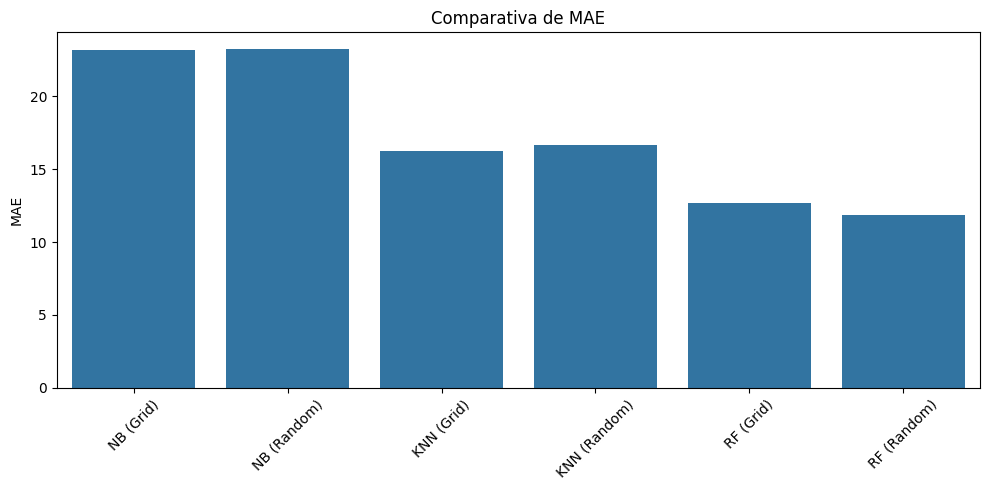

In [15]:
models = [
    'NB (Grid)', 'NB (Random)',
    'KNN (Grid)', 'KNN (Random)',
    'RF (Grid)', 'RF (Random)'
]
mae_scores = [
    mean_absolute_error(y_val, pred_nb_grid),
    mean_absolute_error(y_val, pred_nb_random),
    mean_absolute_error(y_val, pred_knn_grid),
    mean_absolute_error(y_val, pred_knn_random),
    mean_absolute_error(y_val, pred_rf_grid),
    mean_absolute_error(y_val, pred_rf_random)
]

plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=mae_scores)
plt.xticks(rotation=45)
plt.title("Comparativa de MAE")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

## Preparación del csv para subirlo a DrivenData

In [31]:
test_features_numeric = test_features.select_dtypes(include=[np.number]).interpolate().fillna(method='bfill')

training_columns = training_features.columns

missing_cols = set(training_columns) - set(test_features_numeric.columns)
for col in missing_cols:
    test_features_numeric[col] = np.nan

test_features_numeric = test_features_numeric[training_columns]
test_scaled_full = scaler.transform(test_features_numeric)
test_scaled = test_scaled_full[:, selected_features]

submit_pred = final_model.predict(test_scaled)

submission_df = test_features[['city', 'year', 'weekofyear']].copy()
submission_df['total_cases'] = submit_pred.astype(int)

submission_df.to_csv("submission.csv", index=False)

print(submission_df.head())

  city  year  weekofyear  total_cases
0   sj  2008          18           42
1   sj  2008          19           42
2   sj  2008          20           42
3   sj  2008          21           42
4   sj  2008          22           42


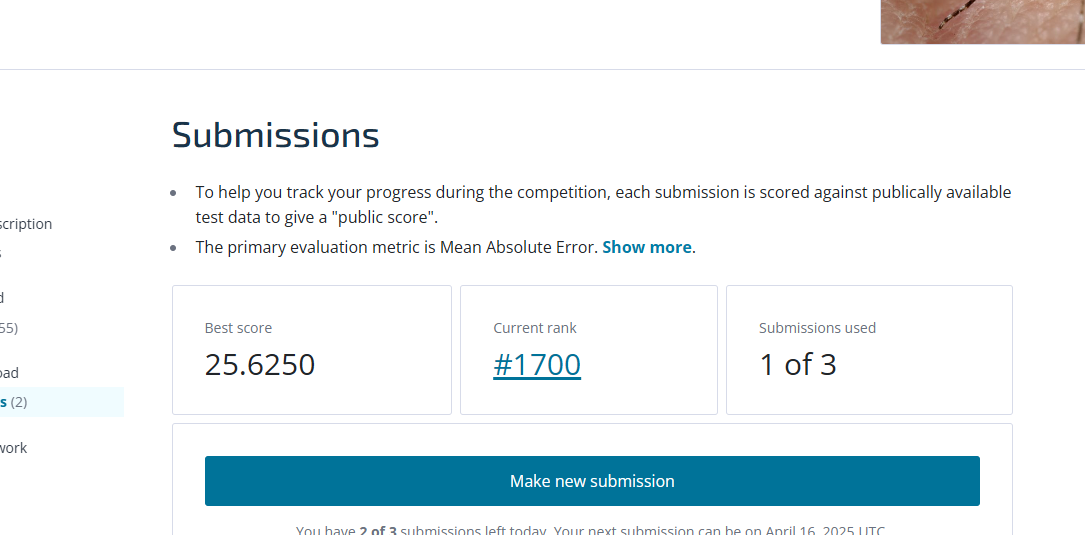